In [1]:
import os
import tempfile
import matplotlib.pylab as plt
import numpy as np
import requests

from torch.utils.data import DataLoader

from torchgeo.datasets import NAIP, ChesapeakeDE, stack_samples, RasterDataset
from torchgeo.datasets.utils import download_url
from torchgeo.samplers import RandomGeoSampler

## Start with torchgeo example

This section considers one of the worked examples given in the torchgeo documentation. When going through it I found there were parts/workings I initially misunderstood - so this section explains why things are the way they are and my current understanding of how it all fits together

In [2]:
# Download the test files we require
naip_file_location = "Modis data/naip"

# Group all of the files referring to NAIP datasets into one object 
naip = NAIP(naip_file_location)

In [3]:
print(naip)

NAIP Dataset
    type: GeoDataset
    bbox: BoundingBox(minx=440055.0, maxx=451549.7999999998, miny=4288884.0, maxy=4303429.2, mint=1534287599.999999, maxt=1541375999.999999)
    size: 3


Notice how the 'size' of the dataset is 3. This is because we have 3 seperate tif files that have been lumped together because they are all NAIP datasets (just referring to different locations/times). However, if you dig into the NAIP class specification you can also see that each tif file contains 4 bands (RGB and one other).

In [4]:
# Define the sampler for the datasets using a random sampler 
sampler = RandomGeoSampler(naip, size=1000, length=10)

The size refers to the geographical boxed area that each sample has the size of (this is in degrees lat/lon not elements - one of the main benefits of torchgeo). The length is the number of samples we wish to take. 

In [5]:
# Now take the samples using a dataloader object
dataloader = DataLoader(naip, sampler=sampler, collate_fn=stack_samples)
for sample in dataloader:
    image = sample["image"]

print(image.shape)

torch.Size([1, 4, 1667, 1667])


Note that the shape of each object is the number of points in the bounding box (can be non-square also) but we also have 4 bands since this type of data has 4 bands. Note that there is no dimension in the sample related to the number of tif files used in the naip object. Essentially what is happening here is that since we didn't specify any bounds on where we wanted the samples to be taken from (could have specified both geolocation and timeframe to sample within), the sampler has taken random samples from any one of the individual tiles of data for each sample (since there were no limits on where sample could come from).

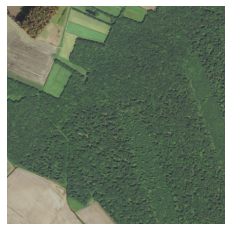

In [6]:
# Use the class's inbuilt plot function to plot the last sample
naip.plot(image)

Note that since this dataset is an image i.e. it has RGB bands where each value is the intensity (not a classification e.g -2 = non-burnable), we need to pass the image object we obtained from the samples above (both image and mask are actually obtained just mask will be empty since not relevant in this case). 

## Base Class for Fire_CCI Datasets

This base class is where attributes and methods that apply to ALL components in the dataset can be applied. If they do not apply to all series then attributes/methods should be within subclass specifications instead. We should try and use this format for other datasets also.

In [7]:
class ModisFireCCI(RasterDataset):
    """Abstract base class for all MODIS Fire CCI Burned Area datasets.

    `MODIS Fire_cci Burned Area Dataset: <https://geogra.uah.es/fire_cci/firecci51.php>`_
    This dataset was developed by ESA, utilising the MODIS satellite. The dataset contains
    information at both PIXEL (~250m) and GRID (0.25 degrees) resolutions. A variety of 
    useful information is contained within the datasets including Julian Day of burn, 
    confidence level of burn etc.
    For more information, see:
    * `User Guide
      <https://climate.esa.int/media/documents/Fire_cci_D4.2_PUG-MODIS_v1.0.pdf>`_
    """

## Make a class for the burn day component

We have to specify all of the necessary attributes that we do not want to be the same as the default specified in the base class (RasterDataset).

In [8]:
class Modis_JD(ModisFireCCI):
    """
    Class for the burn day (in Julian Days) that a burned area is first seen on.
    
    Possible values (mask not image): 
        -2 = pixel not of burnable type e.g. water, urban areas or permanent snow/ice.
        -1 = pixel not observed in the month (possible cloud cover etc)
         0  = pixel is not burned 
        [1,366] = Julian Day of first detection when the pixel is burned 
    """

    filename_glob = "*JD.tif" 
    filename_regex = "(?P<date>\d{6})\S{33}(?P<tile_number>\d).*"
    date_format = "%Y%m" 
    is_image = False
    all_bands = ["Julian Day"]
    binarized_classes = {
        "non-burnable": -2,
        "not observed": -1,
        "no burn": 0,
        "burn": 1
    }
    

In [9]:
ds = Modis_JD("Modis Data")
print(ds)

Modis_JD Dataset
    type: GeoDataset
    bbox: BoundingBox(minx=-26.00109791396346, maxx=52.99930132728768, miny=24.99950094833801, maxy=83.00004990518016, mint=1583020799.999999, maxt=1590965999.999999)
    size: 3


I believe the time is in microseconds and can be converted to datetime if necessary. Since we only specify month and year it seems the limits are the max and min for that whole month as you would expect.

Again, notice how the size of the dataset is 3 since we have used 3 files to make the Modis_JD object. However, since this is a mask dataset (classification not RGB) there is only 1 band. You can see below that this shows up when we take samples.

NOTE: I have tried to access/edit the individual components from the different files, however, I have not been able to do this. You can access different bands of samples but can't seem to seperate the file components. I think this is because the point is for the object to just contain the overall min/max locations and times that are available (these are also stored for each dataset component but are hidden away). We can sample within limited bounds but in general it will be much harder to process data once it is in torchgeo (sampling is easy if random like we want for CNN though).

Thus, I think that we have to do all pre-processing BEFORE putting data into torchgeo (will also be easier to plot/analyse at this point) and only once we are ready to put it in our model should it go into torchgeo. This is because you lose a lot of flexibility with data manipulation but it makes it much easier to do the CNN etc and stops you making mistakes as often. 

So I think we need to write all the preprocessing code seperately (essentially what we have done in notebooks already) and run this before considering the CNN model.

In [10]:
# Specify the sampler and take samples 
sampler = RandomGeoSampler(ds, size=5, length=5)
dl = DataLoader(ds, sampler=sampler, collate_fn=stack_samples)

for sample in dl:
    image = sample['image']
    mask = sample['mask']
    print(mask.shape)

torch.Size([1, 1, 2226, 2226])
torch.Size([1, 1, 2226, 2226])
torch.Size([1, 1, 2226, 2226])
torch.Size([1, 1, 2226, 2226])
torch.Size([1, 1, 2226, 2226])


See how the dimensions are only a matrix since we have 1 band in each sample only. The system DOES NOT work by stacking the datasets according to time and then returning layered samples only inside a bounding box (but all time steps). Instead torchgeo takes samples by limiting BOTH the location and time of the samples. 

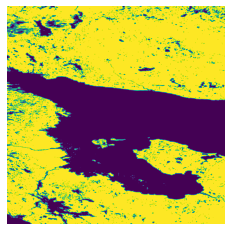

In [11]:
# Plot the final sample using mask 
ds.plot(mask)

## Make a transform to binarize samples  

Transforms are of type torch.nn, so multiple can be cascaded back to back and data samples/batches used as input. I believe this will also make it easy to integrate any transforms with our CNN structure. In the future I think that making datasets one-hot encoded may be treated as a 'transform' before the new data is input to the CNN? 

Here we try to make a transform to binarize samples of the MODIS data.

CHECK: It seems that datasets have allow transforms to be passed to their constructors. I believe this means that these will always be applied when this dataset is sampled/plotted etc. 

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Dict

In [13]:
class Binarize(nn.Module):
    """Maps any data points which are greater than zero to 1."""
    

    def forward(self, inputs: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        """Defines the forward pass behaviour.
        
        Args:
           'inputs': the sample or batch samples obtained from the DataLoader
        """
        
        # Make a copy of the samples
        outputs = inputs

        # Binarize the samples
        outputs["mask"] = torch.where(inputs["mask"] > 0, torch.ones(inputs["mask"].shape,dtype=torch.int32), inputs["mask"])
        return outputs
    
    

In [14]:
# Specify the sampler and take samples 
sampler = RandomGeoSampler(ds, size=25, length=5)
dl = DataLoader(ds, sampler=sampler, collate_fn=stack_samples)
dl = iter(dl)

In [15]:
# Apply the transform to a sample
transform = Binarize()
sample = next(dl)
transformed_sample = sample.copy()
transform(transformed_sample);

tensor(152, dtype=torch.int32)
tensor(1, dtype=torch.int32)


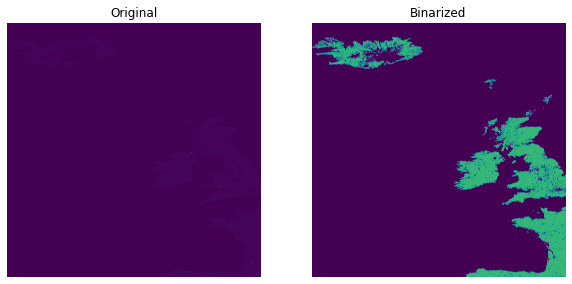

In [16]:
# Plot the result
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 20))

axs[0].imshow(torch.squeeze(sample['mask']))
axs[0].axis("off")
axs[0].title.set_text('Original')
print(sample['mask'].max())

axs[1].imshow(torch.squeeze(transformed_sample['mask']))
axs[1].axis("off")
axs[1].title.set_text('Binarized')
print(transformed_sample['mask'].max())

## Make a transform class for seperating inputs into one-hot encoded bands 

In [17]:
class OneHotEncode(nn.Module):
    """Transforms single layer classification inputs into multiple one-hot encoded bands."""
    
    
    def __init__(self, classes: Dict[str, int]) -> None:
        """Initialises the transform.
        
        Args:
            'classes': a dict containing the different classes found in the input raster.
        """
        
        super().__init__()
        self.classes = classes
    

    def forward(self, inputs: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        """Defines the forward pass behaviour.
        
        Args:
           'inputs': the sample or batch samples obtained from the DataLoader
        """
        
        x_shape = inputs['mask'].shape
                
        # Minimum class value must be equal to zero 
        inputs['mask'] = inputs['mask'] - min(self.classes.values())
        
        # Remove the 'band' dimension since this is always of dimension 1
        input_mask = torch.reshape(inputs['mask'], (x_shape[0],x_shape[2],x_shape[3]))
        
        # Get the one-hot encodings, which are a tensor of: (batch_idx, lat, lon, band_idx)
        encodings = F.one_hot(input_mask.to(torch.int64), num_classes = len(self.classes))
        
        # Create a new mask, which is a tensor of: (batch_idx, band_idx, lat, lon)
        new_mask = torch.zeros([x_shape[0], len(self.classes), x_shape[2], x_shape[3]])
        for band_idx in range(0,len(self.classes)):
            new_mask[:,band_idx,:,:] = encodings[:,:,:,band_idx]
                    
        # Write one-hot encodings to the output tensor 
        outputs = inputs
        outputs['mask'] = new_mask.to(torch.int32)
        return outputs 
        

In [18]:
# Cascade the binarize and one-hot encoding transforms 
transforms = nn.Sequential(
    Binarize(),
    OneHotEncode(ds.binarized_classes),
)

# Apply the cascaded transforms to the same sample
transformed_sample2 = sample.copy()
transforms(transformed_sample2);

tensor(1, dtype=torch.int32)
tensor(1, dtype=torch.int32)
tensor(1, dtype=torch.int32)
tensor(1, dtype=torch.int32)


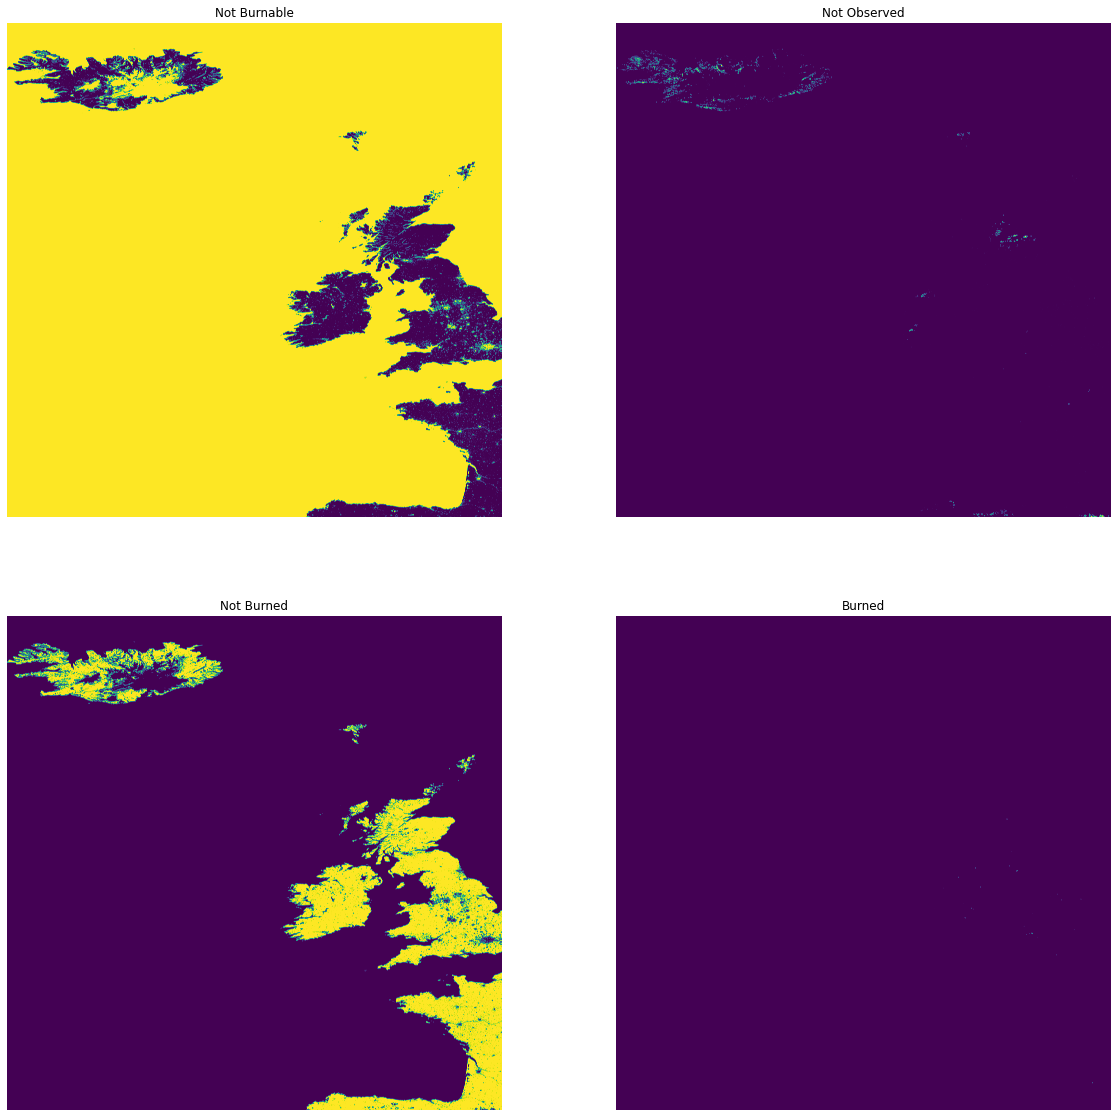

In [19]:
# Plot the result
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

axs[0,0].imshow(torch.squeeze(transformed_sample2['mask'][:,0,:,:]))
axs[0,0].axis("off")
axs[0,0].title.set_text('Not Burnable')
print(transformed_sample2['mask'][:,0,:,:].max())

axs[0,1].imshow(torch.squeeze(transformed_sample2['mask'][:,1,:,:]))
axs[0,1].axis("off")
axs[0,1].title.set_text('Not Observed')
print(transformed_sample2['mask'][:,1,:,:].max())

axs[1,0].imshow(torch.squeeze(transformed_sample2['mask'][:,2,:,:]))
axs[1,0].axis("off")
axs[1,0].title.set_text('Not Burned')
print(transformed_sample2['mask'][:,2,:,:].max())

axs[1,1].imshow(torch.squeeze(transformed_sample2['mask'][:,3,:,:]))
axs[1,1].axis("off")
axs[1,1].title.set_text('Burned')
print(transformed_sample2['mask'][:,3,:,:].max())